# NBA Price Prediction Model Demo

This notebook demonstrates the performance of the trained Transformer model compared to baseline models (Moving Average, Random Forest, XGBoost).

**Key Features:**
- Loads the **exact configuration** used for training (`config.json`).
- Uses the **same training seasons** to train baseline models for fair comparison.
- Tests on **Live Data** from the 2024-25 Season.
- Selects 5 random players from the Top 150 Scorers.
- Predicts stats for Game 20, 40, and 60.

In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import json
import random
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

# Import from our main script
from seqModel import NbaTransformer, loadAndPreprocessData, createSequences, setSeed
from nba_api.stats.endpoints import playergamelogs, leaguedashplayerstats

# Settings
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using Device: {device}")

Using Device: cuda


In [2]:
# --- 1. Load Configuration & Model ---
def load_latest_run(save_dir='savedModels'):
    if not os.path.exists(save_dir):
        return None, None
    
    # Find all 'best_run' folders
    runs = [
        os.path.join(save_dir, d) 
        for d in os.listdir(save_dir) 
        if os.path.isdir(os.path.join(save_dir, d)) and d.startswith('best_run')
    ]
    
    if not runs:
        return None, None
    
    # Get the latest modified folder
    latest_run = max(runs, key=os.path.getmtime)
    print(f"Using Run: {latest_run}")
    
    config_path = os.path.join(latest_run, 'config.json')
    ckpt_path = os.path.join(latest_run, 'model.ckpt')
    
    if not os.path.exists(config_path) or not os.path.exists(ckpt_path):
        print("Missing files in run folder.")
        return None, None
        
    with open(config_path, 'r') as f:
        config = json.load(f)
        
    return config, ckpt_path

config, ckpt_path = load_latest_run()

if config is None:
    raise RuntimeError("No trained model found! Please run 'python seqModel.py' first.")

# Extract params
SEQ_LENGTH = config['seqLength']
TRAIN_SEASONS = config['trainSeasons']
FEATURE_COLS = config.get('featureCols', []) # Load features used in training
TARGET_COLS = config.get('targetCols', ['PTS', 'AST', 'REB'])

print("Configuration Loaded.")
print(f"Training Seasons: {TRAIN_SEASONS}")
print(f"Features ({len(FEATURE_COLS)}): {FEATURE_COLS}")

Using Run: savedModels\best_run_ep20_seq10_d64_head4_lr0.001_bs32
Configuration Loaded.
Training Seasons: [22016, 22017, 22018, 22019, 22020, 22021, 22022]
Features (25): ['PTS', 'AST', 'REB', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'MIN', 'USG_PCT', 'OFF_RATING', 'DEF_RATING', 'PACE', 'TS_PCT']


In [3]:
# --- 2. data Preparation for Baselines ---
print("Loading Historical Data for Baselines...")

# Load ALL data
raw_data, _, _ = loadAndPreprocessData(config['datasetPath'], SEQ_LENGTH)

# Filter for Training Seasons (Exact match with Transformer)
train_df = raw_data[raw_data['SEASON_ID'].isin(TRAIN_SEASONS)].copy()

if train_df.empty:
    raise ValueError("Train Data is empty. Check Season IDs.")

# Create Sequences (Same logic as seqModel)
print(f"Creating sequences (Len={SEQ_LENGTH})...")
x_train_seq, y_train_seq = createSequences(train_df, SEQ_LENGTH, FEATURE_COLS, TARGET_COLS)

# Initialize & Fit Scalers
print("Fitting Scalers...")
scaler_x = StandardScaler().fit(x_train_seq.reshape(-1, len(FEATURE_COLS)))
scaler_y = StandardScaler().fit(y_train_seq)

# Prepare Flat Data for Baselines (N, Seq*Feat)
# Note: RF/XGB usually take flat input. 
# Strategy: We flatten the (Seq, Feat) matrix into a long vector.
x_train_scaled = scaler_x.transform(x_train_seq.reshape(-1, len(FEATURE_COLS))).reshape(x_train_seq.shape)
x_train_flat = x_train_scaled.reshape(x_train_scaled.shape[0], -1)
y_train_raw = y_train_seq # Baselines predict raw values typically, or we can scale. Let's predict raw for simplicity or consistency.
# Actually, usually better to predict scaled for NN, but RF/XGB handle raw fine. 
# HOWEVER, to compare fairly with Transformer which outputs scaled, let's keep it consistent.
# Let's train Baselines on RAW targets to avoid inverse transform issues, 
# and we will inverse transform Transformer output.

print(f"Training Data Shape: {x_train_flat.shape}")

Loading Historical Data for Baselines...
Step 1: Loading and Cleaning Data...
Data Loaded. Total Records: 102538
Creating sequences (Len=10)...
Step 2: Generating Sequences...
Fitting Scalers...
Training Data Shape: (70550, 250)


In [4]:
# --- 3. Train Baseline Models ---
baselines = {}

print("Training Random Forest...")
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(x_train_flat, y_train_raw)
baselines['Random Forest'] = rf

print("Training XGBoost...")
xgb_est = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)
xgb_model = MultiOutputRegressor(xgb_est)
xgb_model.fit(x_train_flat, y_train_raw)
baselines['XGBoost'] = xgb_model

print("Baselines Trained.")

# Load Transformer
print("Loading Transformer...")
transformer = NbaTransformer(
    inputDim=len(FEATURE_COLS),
    dModel=config['dModel'],
    nHead=config['nHead'],
    numLayers=config['numLayers'],
    outputDim=len(TARGET_COLS),
    dropout=config['dropout']
).to(device)

transformer.load_state_dict(torch.load(ckpt_path, map_location=device))
transformer.eval()
print("Transformer Loaded.")

Training Random Forest...
Training XGBoost...
Baselines Trained.
Loading Transformer...
Transformer Loaded.


In [5]:
# --- 4. Live Evaluation Loop ---
TARGET_SEASON = '2024-25'

def get_test_subjects():
    print(f"Fetching Top 150 Scorers for {TARGET_SEASON}...")
    # Get player stats to find top scorers
    stats = leaguedashplayerstats.LeagueDashPlayerStats(
        season=TARGET_SEASON, per_mode_detailed='PerGame'
    ).get_data_frames()[0]
    
    # Filter > 60 games played (assuming late season) or just reasonable amount if early
    # Since it's effectively 2024-25, let's just take top scorers regardless of GP for flexibility,
    # but we will likely need enough games for sequence.
    top_scorers = stats.sort_values('PTS', ascending=False).head(150)
    
    # Pick 5 random
    selected = top_scorers.sample(5)
    return selected[['PLAYER_ID', 'PLAYER_NAME']].values

def fetch_clean_game_log(pid):
    # Fetch Base & Advanced
    try:
        base = playergamelogs.PlayerGameLogs(player_id_nullable=pid, season_nullable=TARGET_SEASON).get_data_frames()[0]
        adv = playergamelogs.PlayerGameLogs(player_id_nullable=pid, season_nullable=TARGET_SEASON, measure_type_player_game_logs_nullable='Advanced').get_data_frames()[0]
        
        if base.empty or adv.empty: return None
        
        # Merge
        merged = pd.merge(base, adv, on=['GAME_ID', 'GAME_DATE'], suffixes=('', '_ADV'))
        merged['GAME_DATE'] = pd.to_datetime(merged['GAME_DATE'])
        merged = merged.sort_values('GAME_DATE').reset_index(drop=True)
        
        # Enforce numeric & Features
        req_cols = FEATURE_COLS + TARGET_COLS
        for c in req_cols:
            if c not in merged.columns:
                merged[c] = 0 # Default padding if API missing col
            merged[c] = pd.to_numeric(merged[c], errors='coerce')
            
        return merged.dropna(subset=req_cols)
    except Exception as e:
        print(f"Error fetching {pid}: {e}")
        return None

# Main Loop
subjects = get_test_subjects()
game_indices = [20, 40, 60]
results = []

print(f"\nEvaluating {len(subjects)} Players: {[s[1] for s in subjects]}")

for pid, pname in subjects:
    print(f"\nProcessing {pname}...")
    df = fetch_clean_game_log(pid)
    
    if df is None or len(df) < max(game_indices) + 1:
        print(f"  Skipping (Not enough games. Has {len(df) if df is not None else 0})")
        continue

    for idx in game_indices:
        # Prepare Input (Previous SEQ_LENGTH games)
        # Range: [idx - seqLen, idx)
        input_slice = df.iloc[idx - SEQ_LENGTH : idx]
        target_slice = df.iloc[idx]
        
        # Features
        feats = input_slice[FEATURE_COLS].values
        
        # Scale Input
        # Note: Must reshape for scaler (TotalSamples, nFeatures)
        feats_scaled = scaler_x.transform(feats)
        
        # 1. Inputs for Transformer (Batch, Seq, Feat)
        input_tensor = torch.FloatTensor(feats_scaled).unsqueeze(0).to(device)
        
        # 2. Inputs for Baselines (Batch, Flat_Features)
        input_flat = feats_scaled.flatten().reshape(1, -1)
        
        # True Values
        y_true = target_slice[TARGET_COLS].values
        
        # --- Predictions ---
        
        # A. Moving Average (Baseline 1)
        pred_ma = input_slice[TARGET_COLS].mean().values
        
        # B. Random Forest (Baseline 2)
        pred_rf = rf.predict(input_flat)[0]
        
        # C. XGBoost (Baseline 3)
        pred_xgb = xgb_model.predict(input_flat)[0]
        
        # D. Transformer (Ours)
        with torch.no_grad():
            out_tensor = transformer(input_tensor)
        # Inverse scale output
        pred_trans = scaler_y.inverse_transform(out_tensor.cpu().numpy())[0]
        
        # Record Results
        # Calculate MAE for this single game prediction
        results.append({'Player': pname, 'Game': idx, 'Model': 'Moving Avg', 'MAE': np.mean(np.abs(y_true - pred_ma))})
        results.append({'Player': pname, 'Game': idx, 'Model': 'Random Forest', 'MAE': np.mean(np.abs(y_true - pred_rf))})
        results.append({'Player': pname, 'Game': idx, 'Model': 'XGBoost', 'MAE': np.mean(np.abs(y_true - pred_xgb))})
        results.append({'Player': pname, 'Game': idx, 'Model': 'Transformer', 'MAE': np.mean(np.abs(y_true - pred_trans))})

results_df = pd.DataFrame(results)
print("Evaluation Complete.")

Fetching Top 150 Scorers for 2024-25...

Evaluating 5 Players: ['Cam Thomas', 'Derrick White', 'Tre Mann', 'Daniel Gafford', 'Michael Porter Jr.']

Processing Cam Thomas...
  Skipping (Not enough games. Has 29)

Processing Derrick White...

Processing Tre Mann...
  Skipping (Not enough games. Has 17)

Processing Daniel Gafford...

Processing Michael Porter Jr....
Evaluation Complete.



Overall Mean Absolute Error (Lower is Better):
Model
Transformer      2.159298
Moving Avg       2.270370
Random Forest    2.277037
XGBoost          2.320253
Name: MAE, dtype: float64


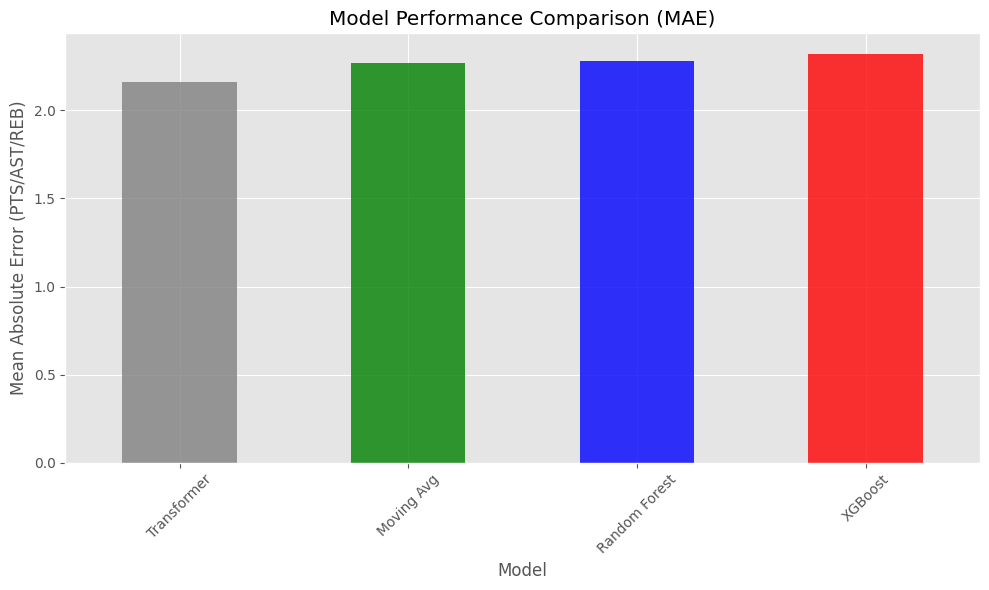

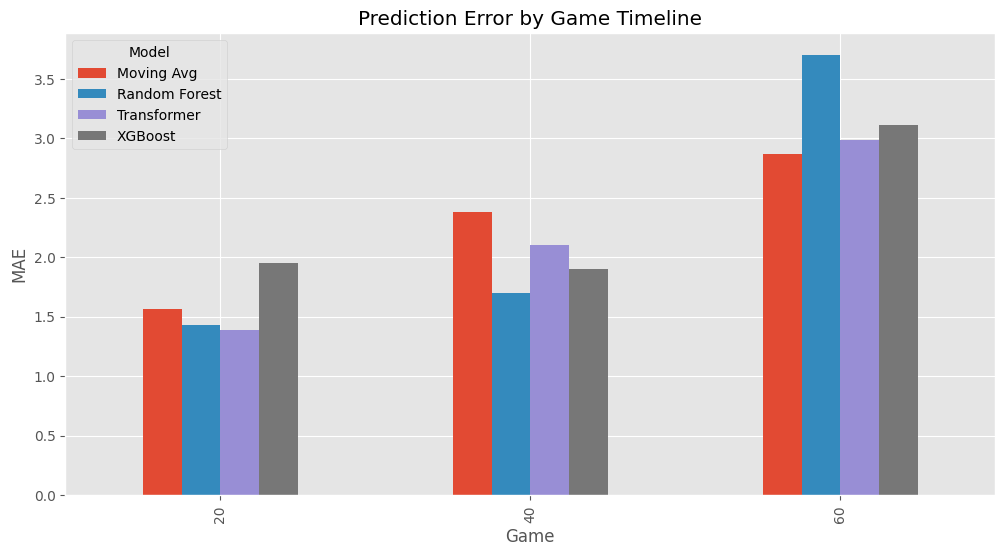

In [6]:
# --- 5. Visualization ---
if not results_df.empty:
    # Aggregate MAE by Model
    summary = results_df.groupby('Model')['MAE'].mean().sort_values()
    print("\nOverall Mean Absolute Error (Lower is Better):")
    print(summary)
    
    # Bar Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    summary.plot(kind='bar', color=['gray', 'green', 'blue', 'red'], alpha=0.8, ax=ax)
    ax.set_title('Model Performance Comparison (MAE)')
    ax.set_ylabel('Mean Absolute Error (PTS/AST/REB)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Grouped Plot by Game Index
    pivot = results_df.pivot_table(index='Game', columns='Model', values='MAE', aggfunc='mean')
    pivot.plot(kind='bar', figsize=(12, 6))
    plt.title('Prediction Error by Game Timeline')
    plt.ylabel('MAE')
    plt.show()
else:
    print("No results to plot.")